# Introduction

Data used for this notebook has new features (from feature engineering), null values are imputed with median and the data is cleaned for modelling purposes. Please refer to Ensemble3(1) notebook in the Github Repo.


This notebook deals with modelling and hypertuning of XGB and Random Forest for regression. The hypertuned models are then used for Stacking and getting an improved result.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [25]:
repository_path = r'C:\\Users\\hugot\\Documents\\Code\\EL_project' #change for your own path or to Drive path

In [27]:
train_x = pd.read_csv(os.path.join(repository_path, 'datasets\\X_train_preprocessed.csv'))

train_x_ids = train_x["ID"] #We keep the IDs in a separate variable
train_x = train_x.drop("ID", axis = 1) #We remove the IDs from the training set
len(train_x.columns)

43

In [28]:
test_x = pd.read_csv(os.path.join(repository_path, 'datasets\\X_test_preprocessed.csv'))
test_x_ids = test_x["ID"] #We keep the IDs in a separate variable
test_x = test_x.drop("ID", axis = 1) #We remove the IDs from the training set
len(test_x.columns)

43

In [29]:
train_y = pd.read_csv(os.path.join(repository_path, 'datasets\\y_train.csv'))

train_y_id = train_y['ID']
train_y = train_y['TARGET']

In [30]:
test_y_random = pd.read_csv(os.path.join(repository_path, 'results\\y_test_random.csv'))

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
from scipy.stats import spearmanr

In [33]:
train_y

0       0.028313
1      -0.112516
2      -0.180840
3      -0.260356
4      -0.071733
          ...   
1489   -0.172597
1490   -0.063546
1491    0.151797
1492   -0.640917
1493   -0.252764
Name: TARGET, Length: 1494, dtype: float64

In [10]:
!pip install optuna

     -------------------------------------- 413.4/413.4 kB 1.5 MB/s eta 0:00:00
     -------------------------------------- 233.4/233.4 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.3 MB/s eta 0:00:00


# Hypertuning Random Forest using Optuna

In [34]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Assuming train_x, train_y are your training data

def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 14)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 14)

    # Create the model with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=0,
    )

    # Use cross-validation to evaluate model performance
    score = cross_val_score(model, train_x, train_y, cv=3, scoring='neg_mean_squared_error').mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can change n_trials to the number of iterations you want

# Best hyperparameters
print('Best hyperparameters:', study.best_params)

# Use the best hyperparameters to create the final model
rfc_best = RandomForestRegressor(**study.best_params, random_state=0)
rfc_best.fit(train_x, train_y)  # Ensure train_y is the correct shape

# Predict on the test set
y_pred_optuna = rfc_best.predict(test_x)


[I 2024-02-16 18:51:21,059] A new study created in memory with name: no-name-62130b24-619c-431d-a8eb-d547cec45c6e
[I 2024-02-16 18:52:01,590] Trial 0 finished with value: -1.101268445674404 and parameters: {'n_estimators': 569, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 0 with value: -1.101268445674404.
[I 2024-02-16 18:52:19,727] Trial 1 finished with value: -1.0550841637930002 and parameters: {'n_estimators': 362, 'max_depth': 32, 'min_samples_split': 11, 'min_samples_leaf': 13}. Best is trial 1 with value: -1.0550841637930002.
[I 2024-02-16 18:52:38,651] Trial 2 finished with value: -1.0543923536580737 and parameters: {'n_estimators': 352, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 13}. Best is trial 2 with value: -1.0543923536580737.
[I 2024-02-16 18:52:53,342] Trial 3 finished with value: -1.056415955288929 and parameters: {'n_estimators': 715, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 2 wi

Best hyperparameters: {'n_estimators': 352, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 13}


In [35]:
print('Best hyperparameters:', study.best_params)

Best hyperparameters: {'n_estimators': 352, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 13}


In [36]:
y_pred_optuna.shape

(654,)

In [37]:
y_pred_final = y_pred_optuna.reshape(-1,1)

In [38]:
y_pred_final.shape

(654, 1)

In [44]:
Y_test_submission = pd.DataFrame(test_x_ids.copy(), columns = ['ID'])

In [45]:
Y_test_submission['TARGET'] = y_pred_final

In [46]:
Y_test_submission

,ID,TARGET
0,1115,0.114092
1,1202,0.086195
2,1194,-0.087826
3,1084,0.151224
4,1135,0.353811
...,...,...
649,879,-0.644640
650,673,0.215810
651,1641,0.655128
652,712,0.525852


In [47]:
path_to_save = os.path.join(repository_path, 'results\\rf_hypertuned.csv')
Y_test_submission.to_csv(path_to_save, index=False)

# Hyper Tuning XGBoost using Optuna

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Assuming train_x, train_y are your training data

def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 100.0)

    # Create the model with the suggested hyperparameters
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        random_state=0,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Use cross-validation to evaluate model performance
    score = cross_val_score(model, train_x, train_y.values, cv=3, scoring='neg_mean_squared_error').mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can change n_trials to the number of iterations you want

# Best hyperparameters
print('Best hyperparameters:', study.best_params)

# Use the best hyperparameters to create the final model
xgb_best = xgb.XGBRegressor(**study.best_params, random_state=0, use_label_encoder=False, eval_metric='logloss')
xgb_best.fit(train_x, train_y.values)  # Ensure train_y is the correct shape

# Predict on the test set
y_pred_optuna_xgb = xgb_best.predict(test_x)


[I 2024-02-15 19:33:49,106] A new study created in memory with name: no-name-d858286f-ce60-4670-b227-eada3aeaf7fa
<ipython-input-48-8f5da401f0ef>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-48-8f5da401f0ef>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
<ipython-input-48-8f5da401f0ef>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

Best hyperparameters: {'n_estimators': 958, 'max_depth': 3, 'learning_rate': 0.012983502840524876, 'subsample': 0.8613472551443894, 'colsample_bytree': 0.8592122590269452, 'gamma': 6.265636328745365e-08, 'reg_lambda': 32.19471816344407, 'reg_alpha': 42.70703483364794}


In [ ]:
print('Best hyperparameters:', study.best_params)

Best hyperparameters: {'n_estimators': 958, 'max_depth': 3, 'learning_rate': 0.012983502840524876, 'subsample': 0.8613472551443894, 'colsample_bytree': 0.8592122590269452, 'gamma': 6.265636328745365e-08, 'reg_lambda': 32.19471816344407, 'reg_alpha': 42.70703483364794}


In [ ]:
y_pred_final_xgb = y_pred_optuna_xgb.reshape(-1,1)

In [ ]:
Y_test_submission_xgb = pd.DataFrame(test_x_ids.copy(), columns = ['ID'])


In [ ]:
Y_test_submission_xgb['TARGET'] = y_pred_final_xgb

In [ ]:
path_to_save = os.path.join(repository_path, 'results\\xgb_hypertuned.csv')
Y_test_submission_xgb.to_csv(path_to_save, index=False)

# Ensemble Method - Stacking (Hypertuned XGB+RF)

Note that the parameters used in the below base models are extracted from above hypertuning of individual models

In [ ]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators= 67, max_depth= 7,random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators = 958, max_depth = 3, learning_rate = 0.012983502840524876, subsample = 0.8613472551443894, colsample_bytree = 0.8592122590269452, gamma = 6.265636328745365e-08, reg_lambda = 32.19471816344407, reg_alpha = 42.70703483364794, random_state=42)
)
]


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor


In [ ]:
meta_model = LinearRegression()


In [ ]:
stacked_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)


In [ ]:
stacked_ensemble.fit(train_x, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py:957: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=7,
                                                     n_estimators=67,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8592122590269452,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=N...
                                            interaction_constraints=None,
                                            learning_rate=0.012983502840524876,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=958, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=LinearRegression())

In [ ]:
predictions = stacked_ensemble.predict(test_x)

In [ ]:
Y_test_submission_stacking = pd.DataFrame(test_x_ids.copy(), columns = ['ID'])

In [ ]:
Y_test_submission_stacking['TARGET'] = predictions

In [ ]:
path_to_save = os.path.join(repository_path, 'results\\stacking_rf_xgb.csv')
Y_test_submission_stacking.to_csv(path_to_save, index=False)

# All submission results

# 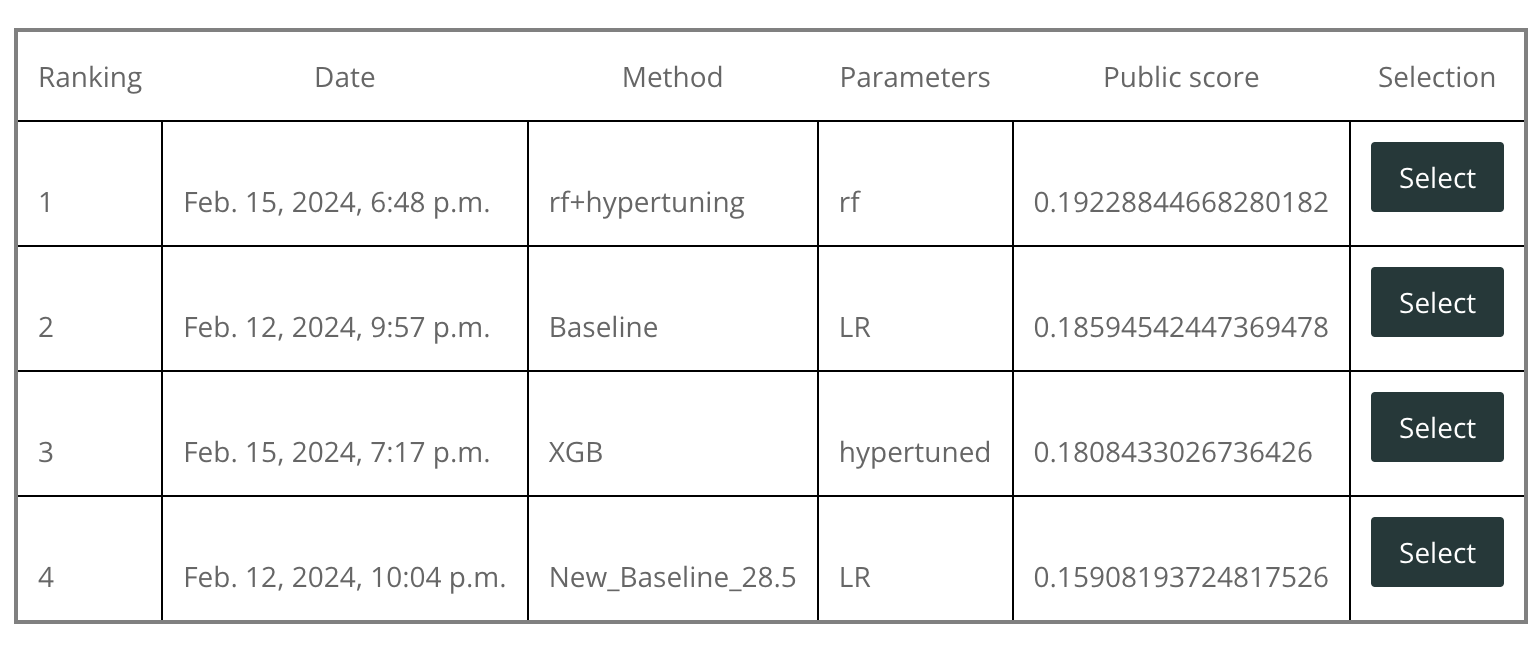

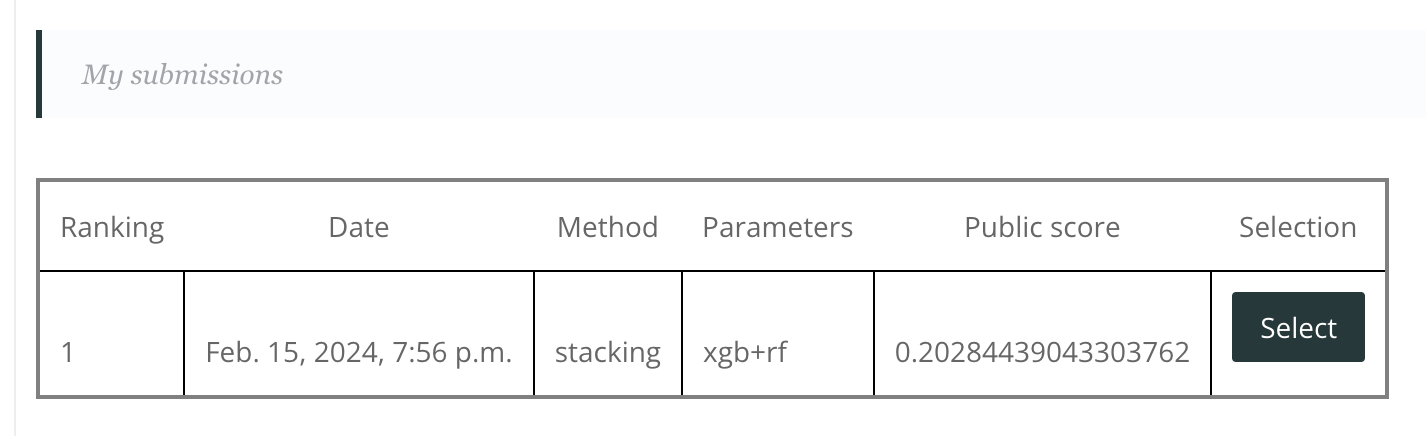